In [51]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels as sm
from numpy.polynomial.polynomial import polyfit
import scipy
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
mpl.rcParams['font.family'] = 'Oswald'

## 1.) Configuration

In [6]:
pwd

'/Users/winsonlam/bulbreferral'

In [7]:
# Note: To run this notebook, you will need to change in the config to your currently working directories.

cfg = {
    "directory": {
        "data": "/Users/winsonlam/bulbreferral/Data",
        "output": "/Users/winsonlam/bulbreferral/Output",
    },
    "color_palette":
    {
        "green": "#07B53B",
        "blue": "#15256B",
        "pink": "#E40093",
        "purple": "#4B0471",
        "black": "#020202"
      },
    'datestring': "%Y-%m-%d",
    'plot': {
        'title_fs': 14,
        'figsize': (11, 4)
    }
}

FILE_CUSTOMER = 'Customer_Info.csv'
FILE_REFERRAL = 'Referrals_Info.csv'

## 2.) Data Preparation

In [8]:
def parseDate(df, col, datestring):
    '''
    Parse the date column from string to datetime
    param df: pd.DataFrame
    param col: date column in string format
    param datestring: date format string i.e. "%Y-%m-%d"
    '''
    df[col] = pd.to_datetime(df[col], format = datestring)
    return df

def addDateFeatures(df, col):
    '''
    Add new date feature columns from datetime colums, i,e week, month ...
    param df: pd.DataFrame 
    param col: the column already in datetime format
    '''
    df['dayofweek'] = df[col].dt.dayofweek
    df['week'] = df[col].dt.week
    df['month'] = df[col].dt.month
    df['quarter'] = df[col].dt.quarter 

    return df

def normaliseToFractions():
    return None

In [9]:
df = pd.read_csv(os.path.join(cfg['directory']['data'], FILE_CUSTOMER))
df = parseDate(df, 'sign_up_date', cfg['datestring'])
df = addDateFeatures(df, 'sign_up_date')

df_ref = pd.read_csv(os.path.join(cfg['directory']['data'], FILE_REFERRAL))
df_ref = parseDate(df_ref, 'referral_date', cfg['datestring'])


In [10]:
df.dtypes

customer_id                 int64
sign_up_date       datetime64[ns]
sign_up_channel            object
dayofweek                   int64
week                        int64
month                       int64
quarter                     int64
dtype: object

In [11]:
# Note: python stores the format (e.g. datetime) in 64-bit integers. We can explicitly format this. For large 
# datasets this can greatly speed up the performance. Since we are dealing with a small file size (<1Mb), we can 
# leave it as is.

In [25]:
# Remove duplicates of customer id but keep latest record
df = df.sort_values('sign_up_date', ascending = False).\
drop_duplicates(subset=['customer_id'], keep = 'first')

## 4.) Data Analysis

### 4.1.) When do members refer?

In [26]:
# Merge customer and referrals info into df_merge
df_merge = pd.merge(df_ref, df, left_on='referrer_customer_id', right_on='customer_id', how = 'left')
df_merge['day_diff'] = (df_merge['referral_date'] - df_merge['sign_up_date']).dt.days
df_merge.head()

referral_date  referrer_customer_id  sign_up_customer_id  customer_id  \
0    2021-07-18                   795                 1771        795.0   
1    2021-04-12                   577                 1510        577.0   
2    2021-07-07                   868                 1858        868.0   
3    2021-10-25                   801                 1778        801.0   
4    2021-08-15                   690                 1637        690.0   

  sign_up_date           sign_up_channel  dayofweek  week  month  quarter  \
0   2021-03-03  Price Comparison Website        2.0   9.0    3.0      1.0   
1   2021-03-28  Price Comparison Website        6.0  12.0    3.0      1.0   
2   2021-03-07              Bulb Website        6.0   9.0    3.0      1.0   
3   2021-04-30                  Referral        4.0  17.0    4.0      2.0   
4   2021-07-29  Price Comparison Website        3.0  30.0    7.0      3.0   

   day_diff  
0     137.0  
1      15.0  
2     122.0  
3     178.0  
4      17.0

In [27]:
assert df_ref.shape[0] == df_merge.shape[0], "There seem to be duplicated customer ID in customer_info"

# Additional Analysis

In [112]:
df_amazingReferrers = df_merge.groupby('referrer_customer_id').filter(lambda g: (g['referrer_customer_id'].size >1) & (g['referrer_customer_id'].size <=10))
# Remove anomaly: referrers who refer more than 1 but less or equal to 10 can be considered genuine. Any referrals more than 10 can be questionnable

In [113]:
sizeReferrer = df_amazingReferrers.groupby('referrer_customer_id').size()
sizeReferrer.name = 'num_of_referrals'

In [114]:
median_daydiff = df_amazingReferrers.groupby(['referrer_customer_id'])['day_diff'].median()
median_daydiff.name = 'median_daydiff'

In [115]:
len(sizeReferrer) == len(median_daydiff)

True

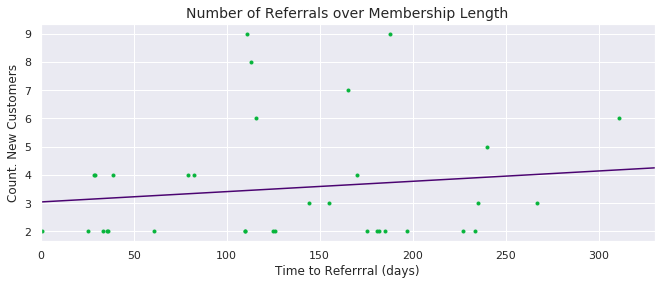

In [116]:
plt.figure(1, figsize = cfg['plot']['figsize'])
df_referrerTime = pd.concat([sizeReferrer, median_daydiff], axis = 1)
df_referrerTime = df_referrerTime.dropna(subset = ['median_daydiff'])
x = df_referrerTime['median_daydiff']
y = df_referrerTime['num_of_referrals']

xp = np.linspace(0, 330, 1000)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.xlim([0, 330])
plt.plot(x, y, '.', c = cfg['color_palette']['green'])
plt.plot(xp, p(xp), '-', c = cfg['color_palette']['purple'])
plt.title('Number of Referrals over Membership Length', fontsize = cfg['plot']['title_fs'])
plt.xlabel('Time to Referrral (days)')
plt.ylabel('Count. New Customers')
plt.savefig(cfg['directory']['output']+ "/Scatter_BestFit_Time_CountNewCustomer.png")

In [117]:
sm.OLS(x, y).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         median_daydiff   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.590
Method:                 Least Squares   F-statistic:                              49.92
Date:                Sat, 26 Oct 2019   Prob (F-statistic):                    4.36e-08
Time:                        17:06:52   Log-Likelihood:                         -203.94
No. Observations:                  34   AIC:                                      409.9
Df Residuals:                      33   BIC:                                      411.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
num_of_referrals    29.2220      4.136      7.065      0.000      20.807      37.637
==============================================================================
Omnibus:                        6.301   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                2.020
Skew:                          -0.044   Prob(JB):                        0.364
Kurtosis:                       1.809   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Trends

<Figure size 792x288 with 0 Axes>

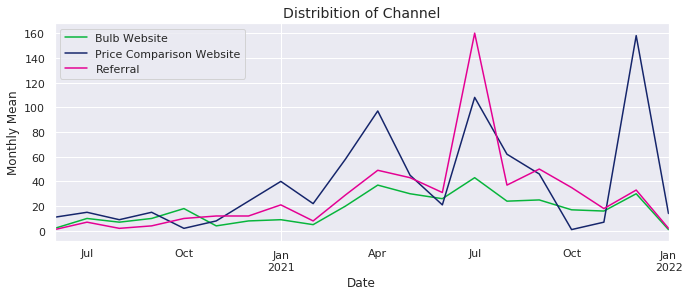

In [118]:
plt.figure(1, figsize = cfg['plot']['figsize'])
ax = df.groupby(['sign_up_date', 'sign_up_channel']).size().unstack().resample('M').sum().plot(color = cfg['color_palette'].values())
plt.xlim(['2020-06', '2022-01'])
ax.legend(title = '', loc='upper left')
plt.xlabel('Date')
plt.ylabel('Monthly Mean')
plt.title('Distribition of Channel', fontsize = cfg['plot']['title_fs'])
plt.savefig(cfg['directory']['output']+ "/Distribution_of_Channel.png")

In [119]:
# Assumption:
# All customers are referrers
# All customers would make at least one referral on the first month of joining Bul
# Question: what is the probability distribution for a customer over time.

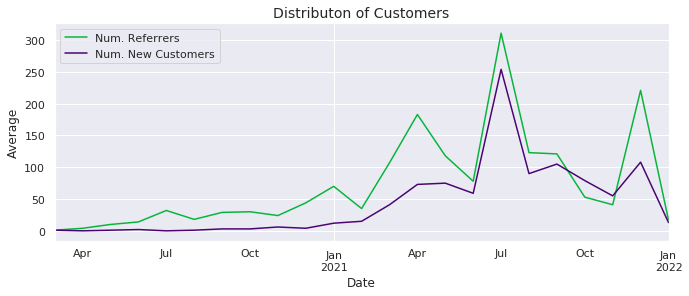

In [120]:
plt.figure(1, figsize = cfg['plot']['figsize'])
n_newCustomers = df_ref.groupby(['referral_date']).size().resample('M').sum().fillna(0)
n_referrers = df.groupby('sign_up_date').size().resample('M').sum().fillna(0)

n_referrers.plot(label = 'Num. Referrers', color = cfg['color_palette']['green'])
n_newCustomers.plot(label = 'Num. New Customers', color = cfg['color_palette']['purple'])

plt.xlim(['2020-03', '2022-01'])
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average')
plt.title('Distributon of Customers', fontsize = cfg['plot']['title_fs'])
plt.savefig(cfg['directory']['output']+ "/Distribution_of_Customers.png")

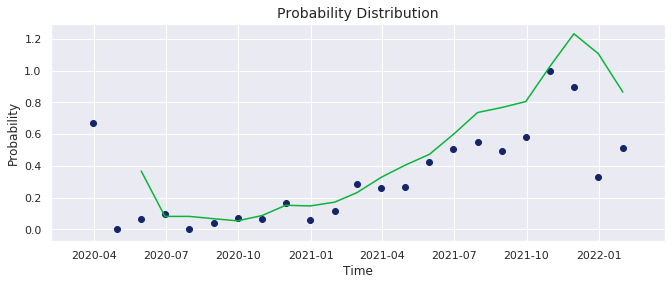

In [122]:
plt.figure(1, figsize = cfg['plot']['figsize'])
prob_dis = (n_newCustomers/n_referrers).dropna()

norm_prob_dis = (prob_dis - prob_dis.min())/(prob_dis.max() - prob_dis.min())
plt.scatter(x = norm_prob_dis.index, y= norm_prob_dis.values, color = cfg['color_palette']['blue'])

prob_rolling = prob_dis.rolling(3, center=False).mean()
plt.plot(prob_rolling.index, prob_rolling.values, color = cfg['color_palette']['green'], label = 'Rolling Average')
plt.title('Probability Distribution', fontsize = cfg['plot']['title_fs'])
plt.ylabel('Probability')
plt.xlabel('Time')
plt.savefig(cfg['directory']['output']+ "/Normalised_Probability_Distribution.png")

/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1, 'Correlation Between Channels')

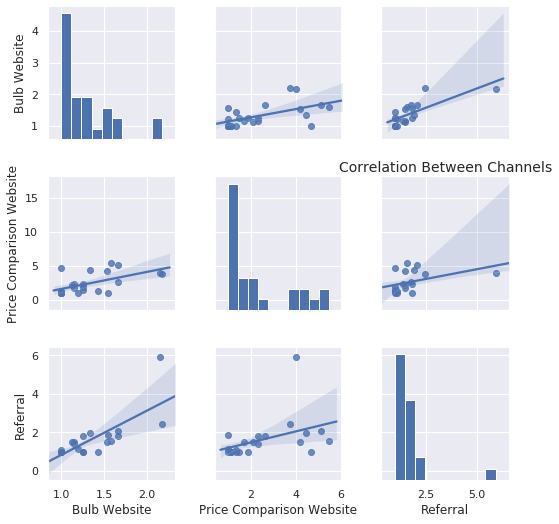

In [123]:
df_corr = df.groupby(['sign_up_date', 'sign_up_channel']).size().unstack().resample('M').mean()
sns.pairplot(df_corr, kind="reg")
plt.title('Correlation Between Channels', fontsize = cfg['plot']['title_fs'])

## ARIMA ON REFERRAL

In [124]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [125]:
Series_referral = df_merge.groupby('referral_date').size().resample('W').sum()
X = Series_referral.values

In [126]:
len(X)

96

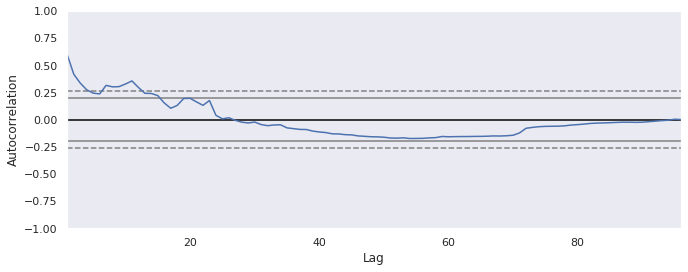

In [127]:
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(X)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   95
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -386.692
Method:                       css-mle   S.D. of innovations             14.144
Date:                Sat, 26 Oct 2019   AIC                            787.384
Time:                        17:07:48   BIC                            805.261
Sample:                             1   HQIC                           794.608
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1674      0.638      0.263      0.793      -1.082       1.417
ar.L1.D.y     -0.4135      0.104     -3.970      0.000      -0.618      -0.209
ar.L2.D.y     -0.3334      0.110     -3.026      0.0

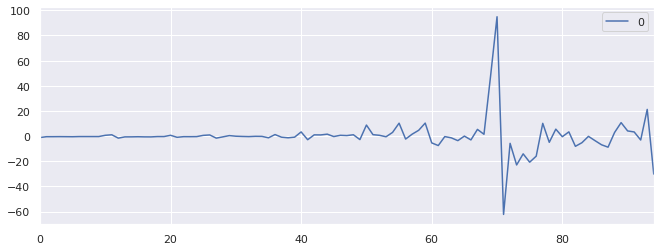

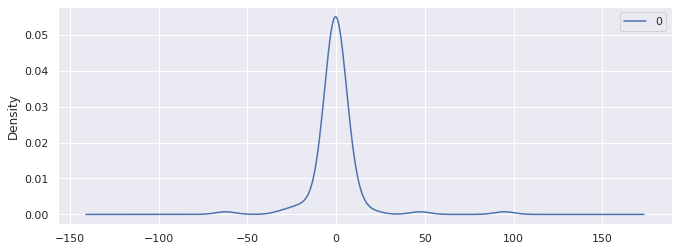

               0
count  95.000000
mean   -0.014237
std    14.219537
min   -62.293496
25%    -1.402068
50%    -0.409680
75%     0.995117
max    94.877636


In [128]:
# fit model
model = ARIMA(X, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

predicted=17.907951, expected=14.000000
predicted=21.924614, expected=14.000000
predicted=11.425591, expected=12.000000
predicted=10.834239, expected=15.000000
predicted=15.616905, expected=12.000000
predicted=12.764247, expected=18.000000
predicted=15.958521, expected=18.000000
predicted=17.456249, expected=64.000000
predicted=55.445616, expected=139.000000
predicted=220.166509, expected=30.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-116.435071, expected=33.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=134.952623, expected=19.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=-2.028436, expected=15.000000
predicted=96.607768, expected=11.000000
predicted=16.193232, expected=16.000000
predicted=18.622831, expected=29.000000
predicted=24.704859, expected=21.000000
predicted=20.019178, expected=26.000000
predicted=24.085997, expected=23.000000
predicted=22.590266, expected=25.000000
predicted=26.111324, expected=16.000000
predicted=18.955506, expected=15.000000
predicted=18.642775, expected=18.000000
predicted=19.023666, expected=16.000000
predicted=17.732495, expected=11.000000
predicted=13.325351, expected=6.000000
predicted=9.472223, expected=13.000000
predicted=13.493064, expected=24.000000
predicted=19.961824, expected=24.000000
predicted=20.469618, expected=24.000000
predicted=21.365632, expected=18.000000
predicted=18.899222, expected=39.000000
predicted=33.907077, expected=1.000000
Test MSE: 2754.132


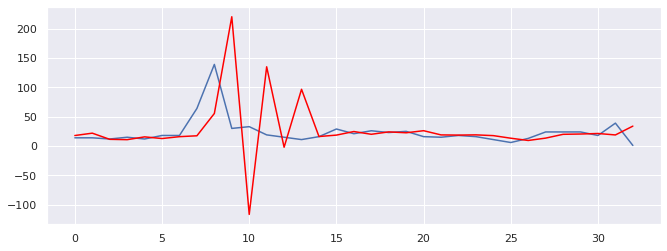

In [129]:

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=20.698989, expected=14.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=23.383937, expected=14.000000
predicted=12.111793, expected=12.000000
predicted=6.899632, expected=15.000000
predicted=15.053744, expected=12.000000
predicted=13.187891, expected=18.000000
predicted=15.656218, expected=18.000000
predicted=17.251137, expected=64.000000
predicted=54.726803, expected=139.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=233.937136, expected=30.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-137.276224, expected=33.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=239.117265, expected=19.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1826: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)


predicted=7.820025, expected=15.000000


/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/chor/miniconda3/envs/galaxyflower/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=129.330254, expected=11.000000
predicted=74.381724, expected=16.000000
predicted=19.184873, expected=29.000000
predicted=26.629850, expected=21.000000
predicted=20.426613, expected=26.000000
predicted=23.975327, expected=23.000000
predicted=21.651124, expected=25.000000
predicted=24.709963, expected=16.000000
predicted=20.153287, expected=15.000000
predicted=18.380242, expected=18.000000
predicted=19.746221, expected=16.000000
predicted=17.985847, expected=11.000000
predicted=14.644587, expected=6.000000
predicted=9.811833, expected=13.000000
predicted=13.437039, expected=24.000000
predicted=20.301363, expected=24.000000
predicted=20.823241, expected=24.000000
predicted=21.266405, expected=18.000000
predicted=17.658752, expected=39.000000
predicted=32.419632, expected=1.000000
Test MSE: 4485.823


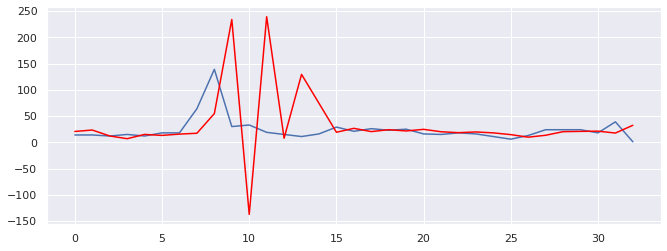

In [309]:

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(4,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()